In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

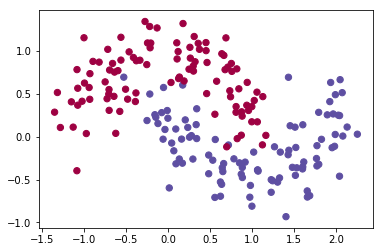

In [2]:
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [3]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [4]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [9]:
clf.predict(X)

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1], dtype=int64)

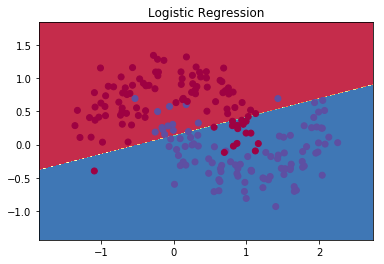

In [5]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

Here we will start the neural network implementation.


In [15]:
num_examples = len(X)
nn_input_dim = 2
nn_output_dim = 2

epsilon = 0.01
reg_lambda = 0.01

Training a neural network means learning the parameters to predict. So how does our network predict?
$$
\begin{aligned}
z_1 &amp; = xW_1 + b_1 \\
a_1 &amp; = \tanh(z_1) \\
z_2 &amp; = a_1W_2 + b_2 \\
a_2 &amp; = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$
now we will let the network train itself , we know it's done training when the loss function aka the error is minimized.
We will use cross entropy loss.
$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

The formula looks complicated, but all it really does is sum over our training examples and add to the loss if we predicted the incorrect class. So, the further away $y$ (the correct labels) and $\hat{y}$ (our predictions) are, the greater our loss will be.
$$
\begin{aligned}
&amp; \delta_3 = \hat{y} - y \\
&amp; \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
&amp; \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
&amp; \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
&amp; \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
&amp; \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

In [11]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

In [12]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)


Finally, here comes the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.

In [13]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068890
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


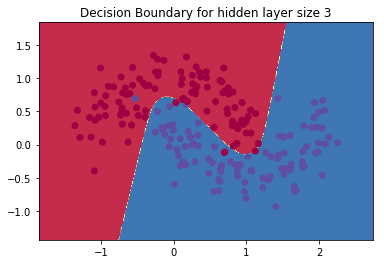

In [16]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

In [ ]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()